In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
!ls drive/'My Drive'/'Colab Notebooks'

 03_CGAN_MNIST.ipynb		    mean-teacher-master
'Chapter_7_SGAN (1).ipynb'	   'mean teacher.v0.mine.ipynb'
'Chapter_7_SGAN (2).ipynb'	   'Mean Teacher.v1.ipynb'
 Chapter_7_SGAN.ipynb		   'SCGAN (1).v1.ipynb'
 Chapter_8_CGAN.ipynb		    SCGAN.v1.ipynb
'Chapter_8_CGAN - 副本 (1).ipynb'   SSGAN-Tensorflow-master
'Chapter_8_CGAN - 副本.ipynb'	    Untitled0.ipynb
 dcgan.ipynb			    Untitled1.ipynb
 full_dataset_vectors.h5	    Untitled2.ipynb
 GAN-tmp.ipynb


In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import json
import time
import h5py

from keras import backend as K
import tensorflow as tf
import keras
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import plotly.graph_objs as go

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape, Embedding,
                          Multiply, MaxPool3D)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D, Conv3DTranspose
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
with h5py.File('drive/My Drive/Colab Notebooks/full_dataset_vectors.h5', 'r') as mnist3d:
    x_train = mnist3d["X_train"][:]
    x_test = mnist3d["X_test"][:]
    y_train = mnist3d["y_train"][:]
    y_test = mnist3d["y_test"][:]

In [17]:
print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)
print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


In [0]:
# def array_to_color(array, cmap="Oranges"):
#     s_m = plt.cm.ScalarMappable(cmap=cmap)
#     return s_m.to_rgba(array)[:,:-1]

# # Transform data from 1d to 3d rgb
# def rgb_data_transform(data):
#     data_t = []
#     for i in range(data.shape[0]):
#         data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
#     return np.asarray(data_t, dtype=np.float32)
  
# xtrain = rgb_data_transform(x_train)
# xtest = rgb_data_transform(x_test)


## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
ytrain = keras.utils.to_categorical(y_train, 10)
ytest = keras.utils.to_categorical(y_test, 10)

In [99]:
print(xtrain.shape)
print(y_train.shape)
print(ytrain.shape)

(10000, 16, 16, 16, 3)
(10000,)
(10000, 10)


In [0]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        self.x_train, self.y_train, self.x_test, self.y_test = xtrain, y_train, xtest, y_test

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [0]:
img_rows = 16
img_cols = 16
img_deps = 16
channels = 3

# Input image dimensions
img_shape = (img_rows, img_cols, img_deps, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

In [0]:
def build_generator(z_dim):
  
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ), dtype='float32')
    label_embedding = Dense(z_dim, input_dim=num_classes)(label)
    print(label_embedding)
    joined_representation = Multiply()([z, label_embedding])
    
#     model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model = Dense(256 * 4 * 4 * 4, input_dim=z_dim)(joined_representation)
    model = Reshape((4, 4, 4, 256))(model)

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model = Conv3DTranspose(128, kernel_size=3, strides=2, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model = Conv3DTranspose(64, kernel_size=3, strides=1, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model = Conv3DTranspose(3, kernel_size=3, strides=2, padding='same')(model)

    # Output layer with tanh activation
    conditioned_img = Activation('tanh')(model)
    
#     conditioned_img = model(joined_representation)

    model = Model([z, label], conditioned_img)

    return model

In [44]:
build_generator(z_dim).summary()

Tensor("dense_13/BiasAdd:0", shape=(?, 100), dtype=float32)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 100)          1100        input_18[0][0]                   
__________________________________________________________________________________________________
multiply_6 (Multiply)           (None, 100)          0           input_17[0][0]                   
                                

In [0]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv3D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv3D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv3D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

In [45]:
build_discriminator_net(img_shape).summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 8, 8, 8, 32)       2624      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 8, 32)       0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 4, 4, 4, 64)       55360     
_________________________________________________________________
batch_normalization_17 (Batc (None, 4, 4, 4, 64)       256       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 4, 4, 4, 64)       0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 2, 2, 2, 128)      221312    
_________________________________________________________________
batch_normalization_18 (Batc (None, 2, 2, 2, 128)     

In [0]:
def build_discriminator_class(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [0]:
def build_discriminator_realOrFake(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

In [0]:
def build_gan(generator, discriminator):
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ))
    img = generator([z, label])
    output = discriminator(img)
    model = Model([z, label], output)

    return model

In [34]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training

discriminator_net = build_discriminator_net(img_shape)

discriminator_realOrFake = build_discriminator_realOfFake(discriminator_net)
discriminator_realOrFake.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=Adam())

discriminator_class = build_discriminator_class(discriminator_net)
discriminator_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
discriminator_realOrFake.summary()

In [38]:
# Build the Generator
generator = build_generator(z_dim)

discriminator_realOrFake.trainable = False
discriminator_class.trainable = False

gan_realOrFake = build_gan(generator, discriminator_realOrFake)
gan_realOrFake.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=Adam())

gan_class = build_gan(generator, discriminator_class)
gan_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())

Tensor("dense_11/BiasAdd:0", shape=(?, 100), dtype=float32)


In [46]:
gan_realOrFake.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 16, 16, 16, 3 2767951     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1)            290314      model_5[1][0]              

In [57]:
gan_class.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 16, 16, 16, 3 2767951     input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 10)           290314      model_5[2][0]              

In [0]:
%mkdir models
%mkdir losses
%mkdir models/models-label-1000
%mkdir losses/losses-label-1000

In [0]:
def train(iterations, batch_size, save_interval, k):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        for _ in range(k):

            # -------------------------
            #  Train the Discriminator
            # -------------------------

            # discriminator_net.trainable = True

            # Get labeled examples
            imgs_labeled, labels = dataset.batch_labeled(batch_size)
            labels = to_categorical(labels, num_classes=num_classes)  # One-hot encode labels

            # Get unlabeled examples
            imgs_unlabeled = dataset.batch_unlabeled(batch_size)

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            fake_labels = to_categorical(fake_labels, num_classes=num_classes)
            imgs_gen = generator.predict([z, fake_labels])

            # Train discriminator
            loss_d_labeled_realOrFake, acc_d_labeled_realOrFake = discriminator_realOrFake.train_on_batch(imgs_labeled, real)
            loss_d_unlabeled_realOrFake, acc_d_unlabeled_realOrFake = discriminator_realOrFake.train_on_batch(imgs_unlabeled, real)
            loss_d_gen_realOrFake, acc_d_gen_realOrFake = discriminator_realOrFake.train_on_batch(imgs_gen, fake)
            loss_d_labeled_class, acc_d_labeled_class = discriminator_class.train_on_batch(imgs_labeled, labels)
            # loss_d_gen_class, acc_d_gen_class = discriminator_class.train_on_batch(imgs_gen, fake_labels)

            # Calculate loss and acc
            loss_d_train_realOrFake = np.add(loss_d_labeled_realOrFake, loss_d_unlabeled_realOrFake)
            # loss_d_class = np.add(loss_d_labeled_class, loss_d_gen_class)
            loss_d_class = loss_d_labeled_class
            loss_d_realOrFake = np.add(loss_d_gen_realOrFake, np.add(loss_d_labeled_realOrFake, loss_d_unlabeled_realOrFake))
            loss_d = np.add(loss_d_class, loss_d_realOrFake)
            # acc_d_class = np.add(acc_d_labeled_class, acc_d_gen_class)/2.0
            acc_d_class = acc_d_labeled_class
            acc_d_realOrFake = np.add(acc_d_gen_realOrFake, np.add(acc_d_labeled_realOrFake, acc_d_unlabeled_realOrFake))/3.0
            acc_d = np.add(acc_d_class, acc_d_realOrFake)/2.0

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Keep Discriminator’s parameters constant for Generator training
        # discriminator_net.trainable = False

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        fake_labels = to_categorical(fake_labels, num_classes=num_classes)

        # Train Generator
        loss_g_realOrFake, acc_g_realOrFake = gan_realOrFake.train_on_batch([z, fake_labels], fake)
        # loss_g_class, acc_g_class = gan_class.train_on_batch([z, fake_labels], fake_labels)

        # Calculate loss
        # loss_g = np.add(loss_g_realOrFake, loss_g_class)
        loss_g = losses_g_realOrFake

        if (iteration + 1) % save_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            losses_d_class.append(loss_d_class)
            losses_d_realOrFake.append(loss_d_realOrFake)
            # losses_g_class.append(loss_g_class)
            losses_g_realOrFake.append(loss_g_realOrFake)
            
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss class: %.4f, acc: %.2f%%] [D loss realOrFake: %.4f, acc:%.2f%%] [G loss realOrFake: %.4f, acc: %.2f%%]"
                % (iteration + 1, 
                    loss_d_class, 100 * acc_d_class,
                    loss_d_realOrFake, 100 * acc_d_realOrFake, 
                    # loss_g_class, 100 * acc_g_class,
                    loss_g_realOrFake, 100 * acc_g_realOrFake))
            
            discriminator_class.save("./models/models-label-" + str(num_labeled) + "/discriminator_class-" + str(iteration+1) + ".h5")
            discriminator_realOrFake.save("./models/models-label-" + str(num_labeled) + "/discriminator_realOrFake-" + str(iteration+1) + ".h5")
            generator.save("./models/models-label-" + str(num_labeled) + "/generator-" + str(iteration+1) + ".h5")
            file1 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_class.json"
            file2 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_realOrFake.json"
            # file3 = "./losses/losses-label-" + str(num_labeled) + "/losses_g_class.json"
            file4 = "./losses/losses-label-" + str(num_labeled) + "/losses_g_realOrFake.json"
            with open(file1, 'w') as json_file:
                  json.dump(str(losses_d_class), json_file)
            with open(file2, 'w') as json_file:
                  json.dump(str(losses_d_realOrFake), json_file)
            # with open(file3, 'w') as json_file:
            #       json.dump(str(losses_g_class), json_file)
            with open(file4, 'w') as json_file:
                  json.dump(str(losses_g_realOrFake), json_file)

In [55]:
# Set hyperparameters
iterations = 4000 # 8000
batch_size = 32
save_interval = 100
num_labeled = 1000  # Number of labeled examples to use (rest will be used as unlabeled)
k = 2 # iteration of Discriminator

# losses_d_labeled_realOrFake = []
# losses_d_unlabeled_realOrFake = []
# losses_d_gen_realOrFake = []
# losses_d_labeled_class = []
# losses_d_gen_class = []
# losses_d_train_realOrFake = []
losses_d_class = []
losses_d_realOrFake = []
losses_d = []
losses_g_realOrFake = []
losses_g_class = []
losses_g = []

iteration_checkpoints = []

dataset = Dataset(num_labeled)

starttime = time.clock()

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, save_interval, k)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



100 [D loss class: 1.3048, acc: 50.00%] [D loss realOrFake: 0.0002, acc:100.00%] [G loss realOrFake: 0.0001, acc: 100.00%]
200 [D loss class: 1.0446, acc: 65.62%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
300 [D loss class: 0.4284, acc: 90.62%] [D loss realOrFake: 0.0002, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
400 [D loss class: 0.5034, acc: 78.12%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
500 [D loss class: 0.2903, acc: 93.75%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
600 [D loss class: 0.1436, acc: 96.88%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
700 [D loss class: 0.0568, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
800 [D loss class: 0.0482, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
900 [D loss cl

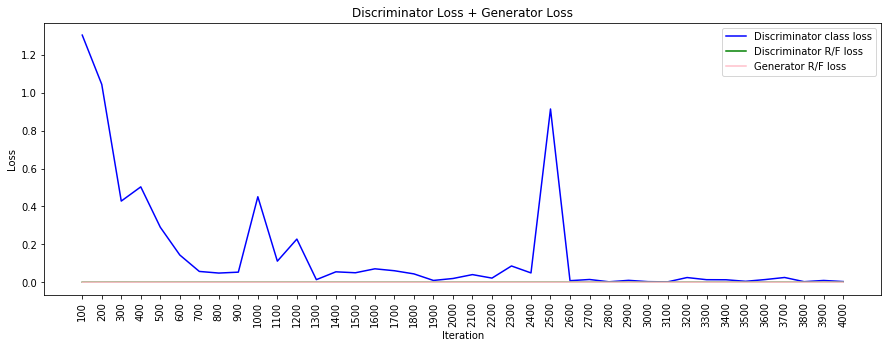

In [56]:
d_class_loss = np.array(losses_d_class)
d_realOrFake_loss = np.array(losses_d_realOrFake)
# g_class_loss = np.array(losses_g_class)
g_realOrFake_loss = np.array(losses_g_realOrFake)
# class_loss = np.add(d_class_loss, g_class_loss)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, d_class_loss, label="Discriminator class loss", color='blue')
plt.plot(iteration_checkpoints, d_realOrFake_loss, label="Discriminator R/F loss", color='green')
# plt.plot(iteration_checkpoints, g_class_loss, label="Generator class loss", color='yellow')
plt.plot(iteration_checkpoints, g_realOrFake_loss, label="Generator R/F loss", color='pink')
# plt.plot(iteration_checkpoints, class_loss, label="Class loss", color='black')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator Loss + Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [64]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

tmodel = build_discriminator_class(discriminator_net)
tmodel.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_class-3700.h5", by_name=False)

# Compute classification accuracy on the training set
_, accuracy = tmodel.evaluate(x, y)
# _, accuracy = discriminator_class.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

1000/1000 [==============================] - 1s 1ms/step
Training Accuracy: 13.20%


2000/2000 [==============================] - 1s 706us/step
0.126


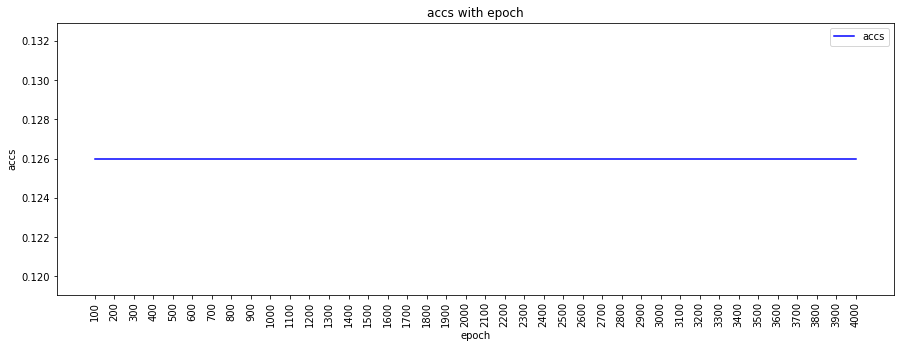

In [78]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

accs = []
tx = [x for x in range(100,4100,100)]
acc_max = [0,0]

for e in tx:
  tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_class-"+ str(e) +".h5", by_name=False)
  _, acc = tmodel.evaluate(x, y)
  accs.append(acc)
print(max(accs))

plt.figure(figsize=(15, 5))
plt.plot(tx, accs, label="accs", color='blue')
plt.xticks(tx, rotation=90)
plt.title("accs with epoch")
plt.xlabel("epoch")
plt.ylabel("accs")
plt.legend()


# tmodel.load_weights("./models/models-label-" + str(num_labeled) + "/discriminator_class-"+e+"3700.h5", by_name=False)

# # Compute classification accuracy on the test set
# _, accuracy = tmodel.evaluate(x, y)
# print("Test Accuracy: %.2f%%" % (100 * accuracy))

In [95]:
t = [0,1,2]
v = np.ndarray((60000,4096,3))
print(v.shape)

(60000, 4096, 3)
